# Transfer learning

[Transfer learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) is a powerful technique that allows sophisticated convolutional neural networks (CNNs) trained by Google, Microsoft, and others on GPUs to be repurposed and used to solve domain-specific problems. With transfer learning, for example, you can take a CNN trained to distinguish between dogs and cats and modify it to distinguish between hot dogs and hambugers. And you can do it on a typical PC or laptop computer — no GPU required.

Many pretrained CNNs are available in the public domain, and several are included with Keras. We will use Keras and Microsoft's [ResNet-50V2](https://keras.io/api/applications/resnet/#resnet50v2-function) pretrained CNN to build a network that distinguishes with a high degree of accuracy between images.

## Load training and testing images

Preprocess the training and testing images, and use label encoding the training and testing labels. The images must be preprocessed the same way the images used to train ResNet-50V2 were preprocessed. This is accomplished by passing them to the `preprocess_input` function and dividing the resulting values by 255.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = 'PlantVillage_split/train'
val_path = 'PlantVillage_split/val'
test_path = 'PlantVillage_split/test'

# Define ImageDataGenerators with preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    rotation_range=20,
    height_shift_range=0.2,  # Shift images vertically
    width_shift_range=0.2,   # Shift images horizontally
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=(0.8, 1.2)
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
validation_generator = train_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 44343 images belonging to 39 classes.
Found 5531 images belonging to 39 classes.
Found 5574 images belonging to 39 classes.


Dataset

In [8]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 39), dtype=tf.float32)
    )
).repeat()

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 39), dtype=tf.float32)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 39), dtype=tf.float32)
    )
)


### Train a classifier with the output from ResNet-50V2

Rather than create a CNN of our own, we will load ResNet-50V2 minus the classification layers and initialize it with the weights arrived at when it was trained on the [ImageNet](http://www.image-net.org/) dataset. We will then run our training and test images through it to extract features from them, and feed the features through our classifier.

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the base model (pre-trained ResNet50V2)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pre-trained weights
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,  # Pre-trained base model
    GlobalAveragePooling2D(),  # Reduce dimensions to a single vector per image
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(1024, activation='relu'),  # Fully connected layer
    Dropout(0.5),
    Dense(39, activation='softmax')  # Output layer for 39 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 39)             │        39,975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,702,951 (98.05 MB)

 Trainable params: 2,138,151 (8.16 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Model Training

In [ ]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the number of epochs and callbacks
epochs = 10
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training after 3 epochs with no improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Reduce learning rate when validation loss plateaus
    factor=0.5,           # Reduce by half
    patience=2,           # Wait for 2 epochs before reducing
    min_lr=1e-6           # Set a minimum learning rate
)


# Calculate steps per epoch
steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)

# Train the model with proper steps and no repeat()
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 2454s 2s/step - accuracy: 0.6126 - loss: 1.4301 - val_accuracy: 0.8696 - val_loss: 0.4197 - learning_rate: 0.0010
Epoch 2/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 2487s 2s/step - accuracy: 0.7800 - loss: 0.7033 - val_accuracy: 0.8711 - val_loss: 0.4280 - learning_rate: 0.0010
Epoch 3/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 2425s 2s/step - accuracy: 0.7984 - loss: 0.6493 - val_accuracy: 0.8921 - val_loss: 0.3625 - learning_rate: 0.0010
Epoch 4/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 2174s 2s/step - accuracy: 0.8041 - loss: 0.6308 - val_accuracy: 0.8951 - val_loss: 0.3418 - learning_rate: 0.0010
Epoch 5/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 2267s 2s/step - accuracy: 0.8132 - loss: 0.6155 - val_accuracy: 0.8915 - val_loss: 0.3537 - learning_rate: 0.0010
Epoch 6/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 2458s 2s/step - accuracy: 0.8100 - loss: 0.6176 - val_accuracy: 0.9006 - val_loss: 0.3312 - learning_rate: 0.0010
Epoch 7/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 2221s 2s/step - accura

Evaluation using test set

In [5]:
# Evaluate on test data
test_steps = max(1, math.ceil(test_generator.samples / test_generator.batch_size))
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

C:\Users\shrij\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9421 - loss: 0.1786
Test Loss: 0.2296261042356491, Test Accuracy: 0.9260854125022888


Saving the model

In [6]:
model.save('plant_village_resnet50v2_39.h5')

Prediction using test set

In [8]:
# Get predictions and true labels
import numpy as np
y_predicted = model.predict(test_generator)
y_predicted_classes = np.argmax(y_predicted, axis=1)  # Get the predicted class indices
y_true = test_generator.classes  # Get the true class indices

175/175 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step


Use a confusion matrix to visualize how well the network performed during testing.

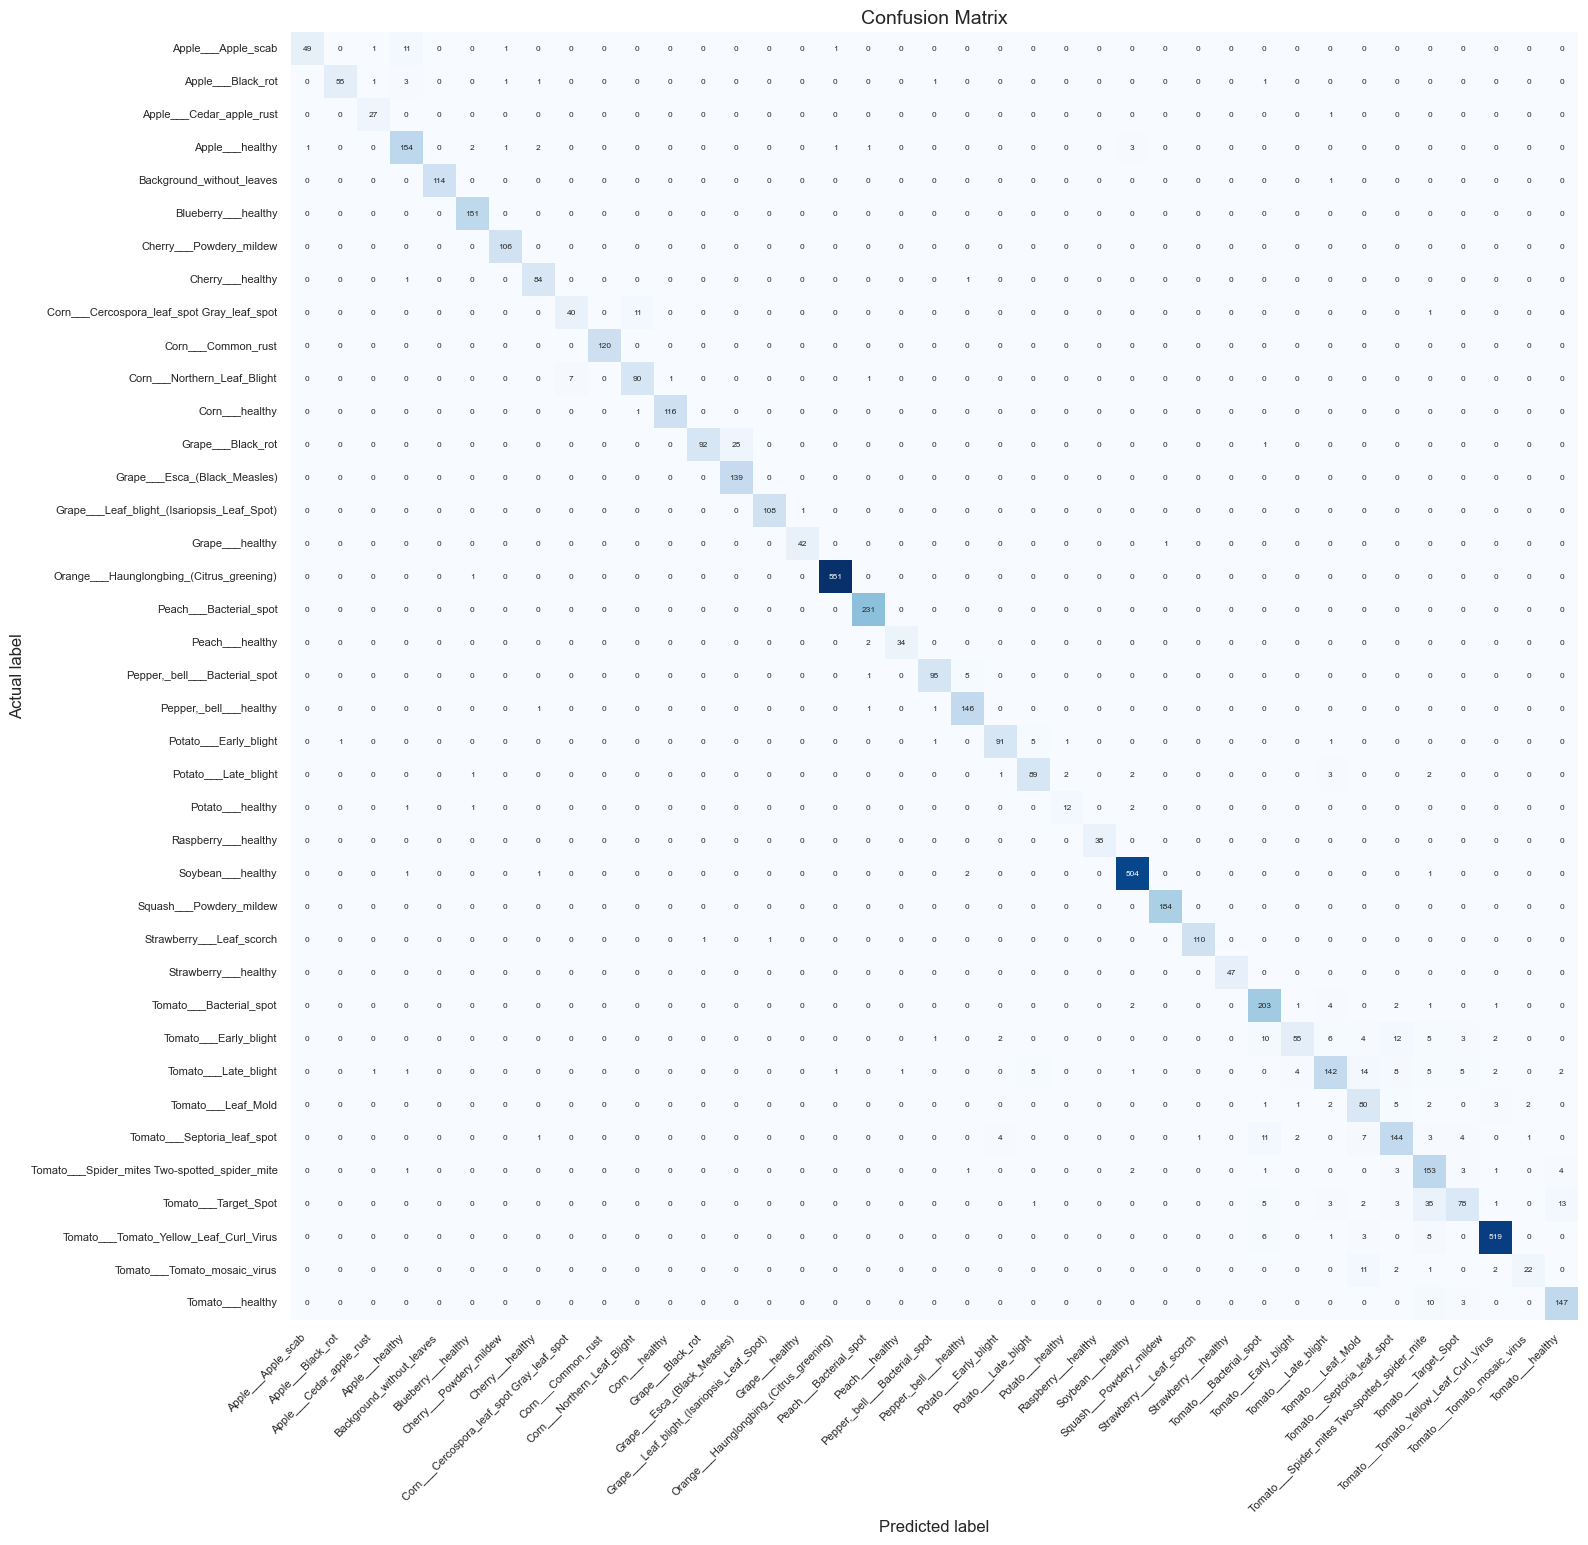

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

# Ensure seaborn style is set
sns.set_theme()

# Compute the confusion matrix
mat = confusion_matrix(y_true, y_predicted_classes)

# Retrieve class labels
class_labels = list(test_generator.class_indices.keys())

# Adjust figure size for better readability
plt.figure(figsize=(16, 16))  # Increase figure size
sns.heatmap(
    mat,
    square=True,
    annot=True,
    fmt='d',
    cbar=False,
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot_kws={"size": 6}  # Reduce font size for annotations
)

plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('Actual label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Adjust layout
plt.tight_layout()

plt.show()


How well did the network train? Let's plot the training accuracy and validation accuracy for each epoch.

[]

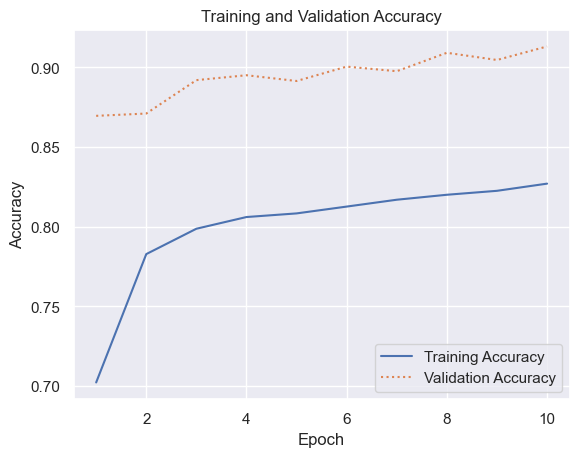

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

[]

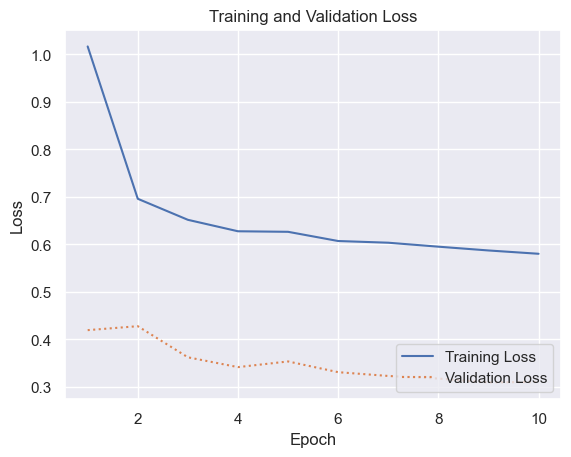

In [11]:
acc = history.history['loss']
val_acc = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Predict the classes for the test data
y_pred_classes = y_predicted.argmax(axis=1)  # Get the predicted class indices

# Calculate precision, recall and f1_score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1score = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1score}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


Precision: 0.9293165622367389
Recall: 0.9260853964836742
F1-score: 0.9245577684180553

Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.98      0.78      0.87        63
                            Apple___Black_rot       0.98      0.87      0.92        63
                     Apple___Cedar_apple_rust       0.90      0.96      0.93        28
                              Apple___healthy       0.89      0.93      0.91       165
                    Background_without_leaves       1.00      0.99      1.00       115
                          Blueberry___healthy       0.97      1.00      0.98       151
                      Cherry___Powdery_mildew       0.97      1.00      0.99       106
                             Cherry___healthy       0.93      0.98      0.95        86
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.85      0.77      0.81        52
                   

Additional finetuning(not done yet)

In [ ]:
# Continue training the model
history_fine_tune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=5,  # Additional epochs
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

In [ ]:
model.save('Crop_model15_resnet50v2_39.keras')

### Prediction for new images

In [4]:
from tensorflow.keras.models import load_model
modelLoaded = load_model('plant_village_resnet50v2_39.h5')

In [2]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
def predict_single_image(model, img_path, class_labels):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    
    return class_labels[predicted_class[0]], predictions[0][predicted_class[0]]

In [35]:
# Predict and display the result
img_path = 'testing/peach.jpg'
predicted_label, confidence = predict_single_image(modelLoaded, img_path, list(train_generator.class_indices.keys()))
print(f"Predicted Class: {predicted_label}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Confidence: 0.51
